In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# 3D rigid discs good rotational inertia

Correct Moment of Inertia for This Case
    J = (1/4) * m * r**2 + (1/12) * m * disc['thickness']**2  # Rotational inertia about diameter
    
Correct for the mass moment of inertia of a solid cylinder about an axis perpendicular to its axis of symmetry and passing through its center — i.e., bending about a diameter of the disc.

Where:

    m = mass of the disc
    r = radius of the disc
    t = thickness of the disc (in the axial direction)

This formula combines:

    (1/4) * m * r**2 : inertia due to rotation about a diameter in the plane of the disc (perpendicular to axis of symmetry),

    (1/12) * m * disc['thickness']**2 : correction due to the finite thickness of the disc.


=== Define the beam and material properties ===
Total beam length [m]: 1
Young's modulus [Pa]: 210e9
Density [kg/m^3]: 7800
Diameter of beam [m]: 0.02

=== Define 2 Rigid Discs ===
Disc 1 position [m]: 0.3
Disc 1 diameter [m]: 0.05
Disc 1 thickness [m]: 0.02
Disc 1 density [kg/m^3]: 7800
Disc 2 position [m]: 0.7
Disc 2 diameter [m]: 0.05
Disc 2 thickness [m]: 0.02
Disc 2 density [kg/m^3]: 7800

=== Define 2 Bearings ===
Bearing 1 position [m]: 0
Bearing 1 translational stiffness [N/m]: 10
Bearing 1 rotational stiffness [Nm/rad]: 10
Bearing 2 position [m]: 1
Bearing 2 translational stiffness [N/m]: 10
Bearing 2 rotational stiffness [Nm/rad]: 10
Natural frequencies (Y plane):
w_y_1: 35.41 Hz
w_y_2: 135.07 Hz
w_y_3: 358.82 Hz
w_y_4: 613.67 Hz
w_y_5: 870.64 Hz
w_y_6: 1381.17 Hz

Natural frequencies (Z plane):
w_z_1: 35.41 Hz
w_z_2: 135.07 Hz
w_z_3: 358.82 Hz
w_z_4: 613.67 Hz
w_z_5: 870.64 Hz
w_z_6: 1381.17 Hz


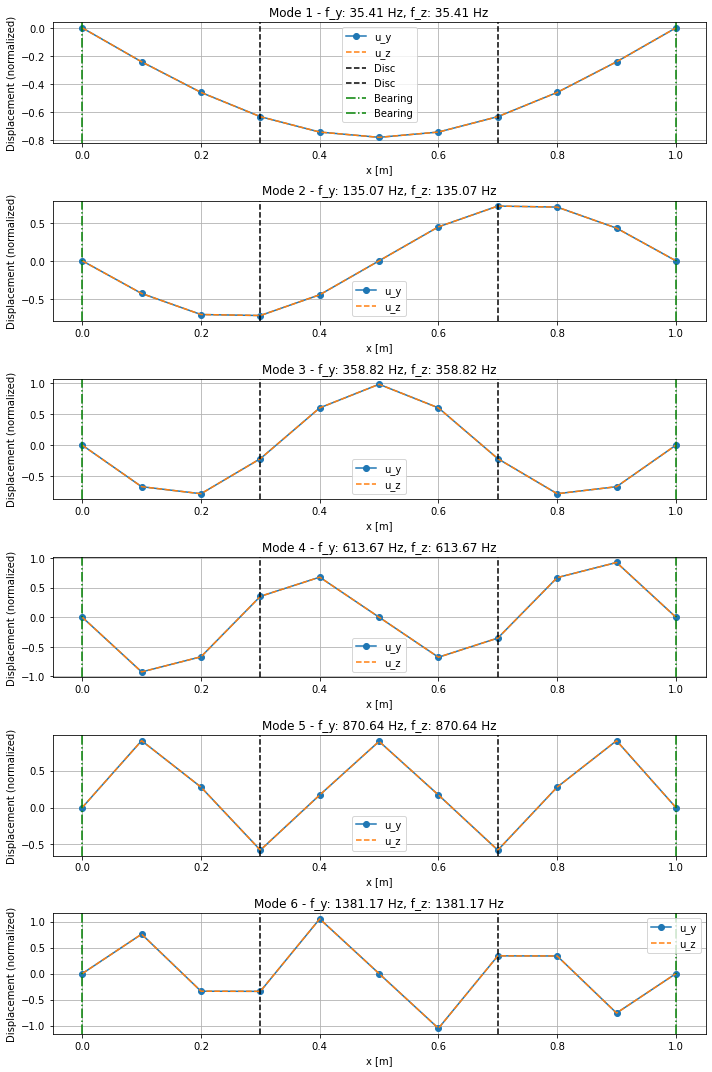

In [4]:
# === USER INPUT FOR BEAM AND MATERIAL PROPERTIES ===
print("\n=== Define the beam and material properties ===")
L = float(input("Total beam length [m]: "))
E = float(input("Young's modulus [Pa]: "))
rho = float(input("Density [kg/m^3]: "))
D  = float(input("Diameter of beam [m]: "))
I = (np.pi * D**4) / 64     # Moment of inertia [m^4]
A = (np.pi * D**2) / 4      # Cross-sectional area [m^2]

# === FEM discretization ===
n_elem = 10
n_nodes = n_elem + 1
dof_per_node = 2  # per plane: [u, theta]
total_dof = dof_per_node * n_nodes
dx = L / n_elem

# === Element stiffness and mass matrices (4x4 for each plane) ===
def beam_element_matrices(E, I, rho, A, L):
    K_local = (E * I / L**3) * np.array([
        [12, 6*L, -12, 6*L],
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L, 12, -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]
    ])
    
    M_local = (rho * A * L / 420) * np.array([
        [156, 22*L, 54, -13*L],
        [22*L, 4*L**2, 13*L, -3*L**2],
        [54, 13*L, 156, -22*L],
        [-13*L, -3*L**2, -22*L, 4*L**2]
    ])
    
    return K_local, M_local

# === Initialize global matrices for Y and Z planes ===
K_global_y = np.zeros((total_dof, total_dof))
M_global_y = np.zeros((total_dof, total_dof))

K_global_z = np.zeros((total_dof, total_dof))
M_global_z = np.zeros((total_dof, total_dof))

# === Assembly ===
K_local, M_local = beam_element_matrices(E, I, rho, A, dx)

for e in range(n_elem):
    dof_map = [2*e, 2*e+1, 2*e+2, 2*e+3]
    
    for i in range(4):
        for j in range(4):
            K_global_y[dof_map[i], dof_map[j]] += K_local[i, j]
            M_global_y[dof_map[i], dof_map[j]] += M_local[i, j]
            K_global_z[dof_map[i], dof_map[j]] += K_local[i, j]
            M_global_z[dof_map[i], dof_map[j]] += M_local[i, j]
            
            
            
            
#=============================================================================================================================
# === USER INPUT FOR 2 DISCS ===
print("\n=== Define 2 Rigid Discs ===")
disc1_pos = float(input("Disc 1 position [m]: "))   # [m] position along beam
disc1_diam = float(input("Disc 1 diameter [m]: "))   # [m] diameter of rigid disc
disc1_thick = float(input("Disc 1 thickness [m]: "))   # [m] axial thickness
disc1_density = float(input("Disc 1 density [kg/m^3]: "))   # [kg/m³] (same as beam material)

disc2_pos = float(input("Disc 2 position [m]: "))
disc2_diam = float(input("Disc 2 diameter [m]: "))
disc2_thick = float(input("Disc 2 thickness [m]: "))
disc2_density = float(input("Disc 2 density [kg/m^3]: "))


# === Add Discs ===
# Store all disc properties in a list of dictionaries
discs = [
    {'pos': disc1_pos, 'diameter': disc1_diam, 'thickness': disc1_thick, 'density': disc1_density},
    {'pos': disc2_pos, 'diameter': disc2_diam, 'thickness': disc2_thick, 'density': disc2_density}
]

# === ADD DISCS TO GLOBAL MASS MATRIX ===                      CHANGED!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
for disc in discs:
    r = disc['diameter'] / 2
    m = disc['density'] * np.pi * r**2 * disc['thickness']  # Mass of the disc
    J = (1/4) * m * r**2 + (1/12) * m * disc['thickness']**2  # Rotational inertia about diameter axis (appropriate for lateral bending)

    # Map position to nearest node
    node = int(round(disc['pos'] / dx))
    node = np.clip(node, 0, n_nodes - 1)  # Ensure within bounds

    # DOFs for each plane (2 per node)
    dof_y = 2 * node       # [v, theta_z]
    dof_z = 2 * node       # [w, theta_y]

    # Y-plane additions
    M_global_y[dof_y, dof_y] += m                     # Translational mass (Y)
    M_global_y[dof_y + 1, dof_y + 1] += J             # Rotational inertia (θz)

    # Z-plane additions
    M_global_z[dof_z, dof_z] += m                     # Translational mass (Z)
    M_global_z[dof_z + 1, dof_z + 1] += J             # Rotational inertia (θy)



# === USER INPUT FOR FLEXIBLE BEARINGS ===
print("\n=== Define 2 Bearings ===")
bear1_pos = float(input("Bearing 1 position [m]: "))   # [m] position along beam
bear1_k = float(input("Bearing 1 translational stiffness [N/m]: ")) # [N/m] translational stiffness (flexibility of the bearing)
bear1_kr = float(input("Bearing 1 rotational stiffness [Nm/rad]: ")) # [Nm/rad] rotational stiffness of bearing (optional)

bear2_pos = float(input("Bearing 2 position [m]: "))
bear2_k = float(input("Bearing 2 translational stiffness [N/m]: "))
bear2_kr = float(input("Bearing 2 rotational stiffness [Nm/rad]: "))


# === Add Bearings ===
# Store bearing properties
bearings = [
    {'pos': bear1_pos, 'k': bear1_k, 'kr': bear1_kr},
    {'pos': bear2_pos, 'k': bear2_k, 'kr': bear2_kr}
]

# === ADD BEARING STIFFNESS TO GLOBAL STIFFNESS MATRIX ===       CHANGED!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
for b in bearings:
    node = int(round(b['pos'] / dx))
    node = np.clip(node, 0, n_nodes - 1)

    dof_y = 2 * node       # [v, θz] in Y plane
    dof_z = 2 * node       # [w, θy] in Z plane

    # Add translational stiffness
    K_global_y[dof_y, dof_y] += b['k']
    K_global_z[dof_z, dof_z] += b['k']
    
    # Add rotational stiffness
    K_global_y[dof_y + 1, dof_y + 1] += b['kr']
    K_global_z[dof_z + 1, dof_z + 1] += b['kr']
    
#=============================================================================================================================  
    

# === Boundary conditions (simply supported at both ends) ===
# Fix displacement DOF at node 0 and last node
constrained_dofs = [0, dof_per_node*(n_nodes-1)]

free_dofs = np.setdiff1d(np.arange(total_dof), constrained_dofs)

# === Reduce matrices ===
K_reduced_y = K_global_y[np.ix_(free_dofs, free_dofs)]
M_reduced_y = M_global_y[np.ix_(free_dofs, free_dofs)]

K_reduced_z = K_global_z[np.ix_(free_dofs, free_dofs)]
M_reduced_z = M_global_z[np.ix_(free_dofs, free_dofs)]

# === Solve eigenvalue problem for Y and Z planes ===
eigvals_y, eigvecs_y = eigh(K_reduced_y, M_reduced_y)
eigvals_z, eigvecs_z = eigh(K_reduced_z, M_reduced_z)

freqs_y = np.sqrt(eigvals_y) / (2 * np.pi)
freqs_z = np.sqrt(eigvals_z) / (2 * np.pi)

# === Print frequencies ===
print("Natural frequencies (Y plane):")
for i, f in enumerate(freqs_y[:6]):
    print(f"w_y_{i+1}: {f:.2f} Hz")

print("\nNatural frequencies (Z plane):")
for i, f in enumerate(freqs_z[:6]):
    print(f"w_z_{i+1}: {f:.2f} Hz")

# === Plot mode shapes ===
x = np.linspace(0, L, n_nodes)
n_modes = min(6, len(freqs_y))

plt.figure(figsize=(10, 2.5 * n_modes))

for i in range(n_modes):
    # reconstruct full mode shape
    mode_y = np.zeros(total_dof)
    mode_z = np.zeros(total_dof)
    mode_y[free_dofs] = eigvecs_y[:, i]
    mode_z[free_dofs] = eigvecs_z[:, i]
    
    w_y = mode_y[::dof_per_node]
    w_z = mode_z[::dof_per_node]
    
    #w_y /= np.max(np.abs(w_y))
    #w_z /= np.max(np.abs(w_z))
    
    plt.subplot(n_modes, 1, i+1)
    plt.plot(x, w_y, '-o', label='u_y')
    plt.plot(x, w_z, '--', label='u_z')
    
    #================================================================================================================
    # === Mark disc positions ===
    for disc in discs:
        disc_node = int(round(disc['pos'] / dx))
        disc_x = disc_node * dx
        plt.axvline(x=disc_x, color='k', linestyle='--', label='Disc' if i == 0 else "")
    
    # === Mark bearing positions ===
    for b in bearings:
        bear_node = int(round(b['pos'] / dx))
        bear_x = bear_node * dx
        plt.axvline(x=bear_x, color='g', linestyle='-.', label='Bearing' if i == 0 else "")
#================================================================================================================
    
    
    plt.title(f"Mode {i+1} - f_y: {freqs_y[i]:.2f} Hz, f_z: {freqs_z[i]:.2f} Hz")
    plt.xlabel("x [m]")
    plt.ylabel("Displacement (normalized)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()